### Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C, PPO

import quantstats as qs

### Create Env

In [14]:
import yfinance as yf

df = yf.Ticker("ADBE")
df = df.history(period="max")
df = df.loc['2022-01-01':, :]

# Calculate Moving Averages ['Open', 'High', 'Low', 'Close', 'Volume']
df['SMA'] = df['Close'].rolling(window=5).mean()  # Short-term moving average
df['LMA'] = df['Close'].rolling(window=20).mean()  # Long-term moving average

# Calculate RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
# Handling NaN values that may appear due to the rolling and ewm functions
df.fillna(0, inplace=True)

window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


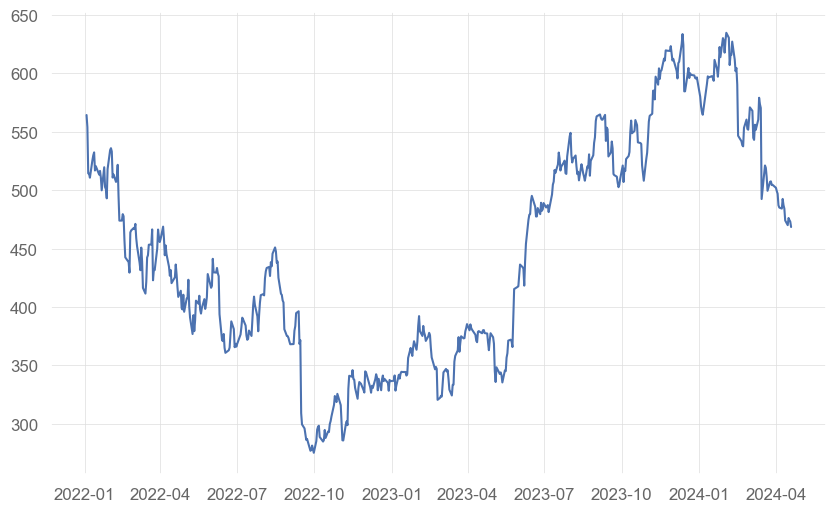

In [15]:
plt.plot(df.Close)

In [6]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

# window_size = 10
# start_index = window_size
# end_index = len(df)

# env = gym.make(
#     'stocks-v0',
#     df=df,
#     window_size=window_size,
#     frame_bound=(start_index, end_index)
# )

# print("observation_space:", env.observation_space)

### Train Env

In [7]:
# env.reset(seed=2023)
# model = A2C('MlpPolicy', env, verbose=0, seed=2023)
# model.learn(total_timesteps=1000)

In [16]:
env.reset(seed=2023)
model = PPO('MlpPolicy', env, verbose=0, seed=2023)
model.learn(total_timesteps=100)

### Test Env

In [17]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 336, <Actions.Buy: 1>: 230}
info: {'total_reward': -67.61953735351562, 'total_profit': 0.123273875638522, 'position': <Positions.Long: 1>}


### Plot Results

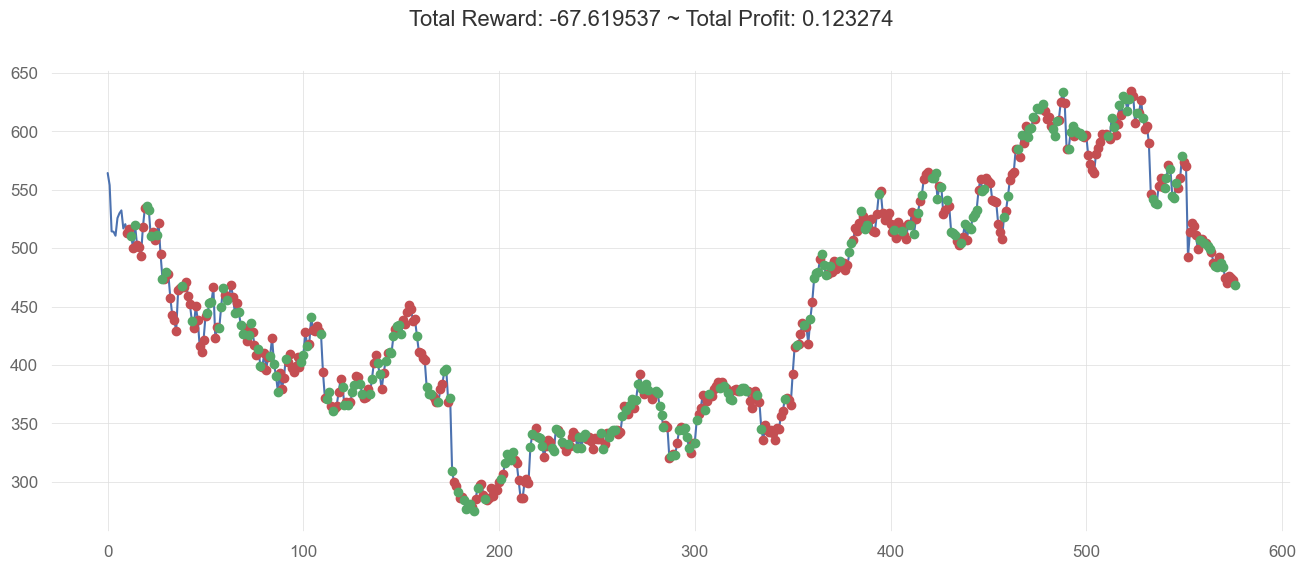

In [18]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

### Analysis Using `quantstats`

In [19]:
env.unwrapped.history['total_profit']

[1.0,
 1.0,
 0.9639548658585636,
 0.9639548658585636,
 0.9185903381244356,
 0.9185903381244356,
 0.9185903381244356,
 0.9185903381244356,
 0.9185903381244356,
 0.9185903381244356,
 0.9185903381244356,
 0.9185903381244356,
 0.8669735301725516,
 0.8669735301725516,
 0.8669735301725516,
 0.8714496236657738,
 0.8714496236657738,
 0.8714496236657738,
 0.8584939124817346,
 0.8584939124817346,
 0.842484920360224,
 0.842484920360224,
 0.842484920360224,
 0.842484920360224,
 0.842484920360224,
 0.842484920360224,
 0.842484920360224,
 0.842484920360224,
 0.8281152887109534,
 0.8281152887109534,
 0.8281152887109534,
 0.8281152887109534,
 0.8281152887109534,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8037402277142376,
 0.8310825160886918,
 0.8310825160886918,
 0.8310825160886918,
 0.8310825160886918,
 0.8310825160886918,
 0.8310825160886918,
 0.872600

In [11]:
pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])

Date
2022-01-19 00:00:00-05:00    1.000000
2022-01-20 00:00:00-05:00    1.000000
2022-01-21 00:00:00-05:00    0.963955
2022-01-24 00:00:00-05:00    0.963955
2022-01-25 00:00:00-05:00    0.918590
                               ...   
2024-04-12 00:00:00-04:00    0.087679
2024-04-15 00:00:00-04:00    0.087679
2024-04-16 00:00:00-04:00    0.087679
2024-04-17 00:00:00-04:00    0.087679
2024-04-18 00:00:00-04:00    0.087679
Length: 565, dtype: float64

In [12]:
net_worth.pct_change().iloc[1:].head(200)

NameError: name 'net_worth' is not defined

In [ ]:
pd.set_option('display.max_rows', 500)

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

                           Strategy
-------------------------  ----------
Start Period               2022-01-20
End Period                 2024-04-18
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -88.11%
CAGR﹪                     -48.07%

Sharpe                     -2.7
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -2.62
Sortino                    -2.99
Smart Sortino              -2.9
Sortino/√2                 -2.11
Smart Sortino/√2           -2.05
Omega                      0.35

Max Drawdown               -88.45%
Longest DD Days            805
Volatility (ann.)          33.04%
Calmar                     -0.54
Skew                       -2.98
Kurtosis                   25.94

Expected Daily %           -0.38%
Expected Monthly %         -7.32%
Expected Yearly %          -50.83%
Kelly Criterion            -60.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.78%
Expected Shortfall (cVaR)  -3.78%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-02-04,2024-04-18,2024-04-18,804,-88.445914,-87.518529
2,2022-01-21,2022-01-21,2022-01-28,8,-3.604513,NaN


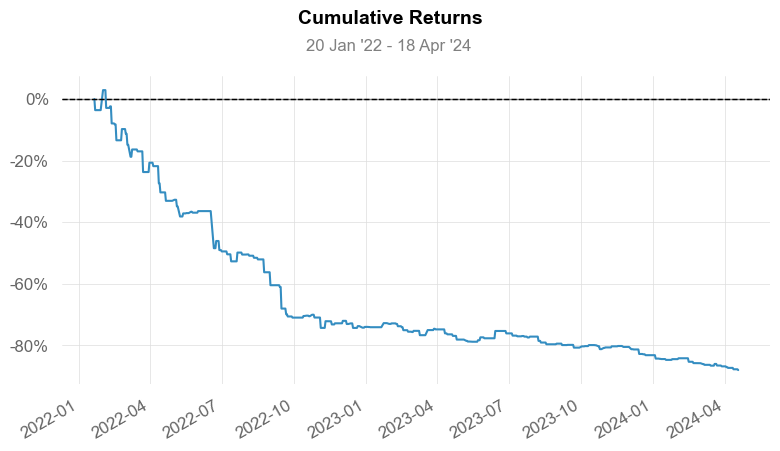

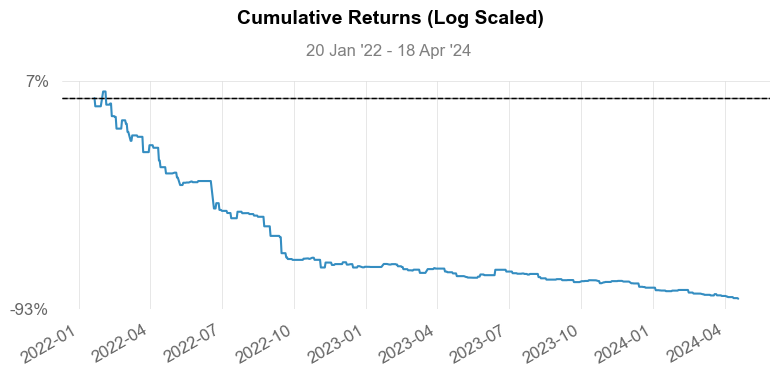

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


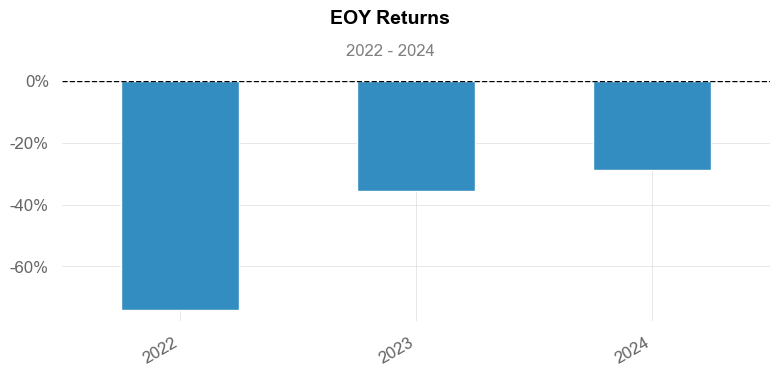

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

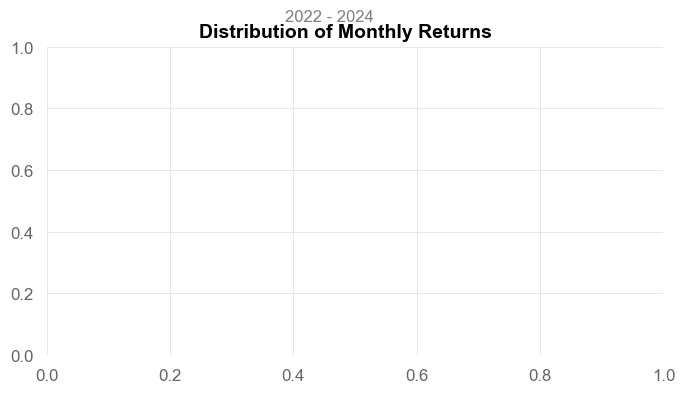

In [ ]:
qs.reports.full(returns)

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

                           Strategy
-------------------------  ----------
Start Period               2022-01-20
End Period                 2024-04-18
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -88.11%
CAGR﹪                     -48.07%

Sharpe                     -2.7
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -2.62
Sortino                    -2.99
Smart Sortino              -2.9
Sortino/√2                 -2.11
Smart Sortino/√2           -2.05
Omega                      0.35

Max Drawdown               -88.45%
Longest DD Days            805
Volatility (ann.)          33.04%
Calmar                     -0.54
Skew                       -2.98
Kurtosis                   25.94

Expected Daily %           -0.38%
Expected Monthly %         -7.32%
Expected Yearly %          -50.83%
Kelly Criterion            -60.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.78%
Expected Shortfall (cVaR)  -3.78%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-02-04,2024-04-18,2024-04-18,804,-88.445914,-87.518529
2,2022-01-21,2022-01-21,2022-01-28,8,-3.604513,NaN


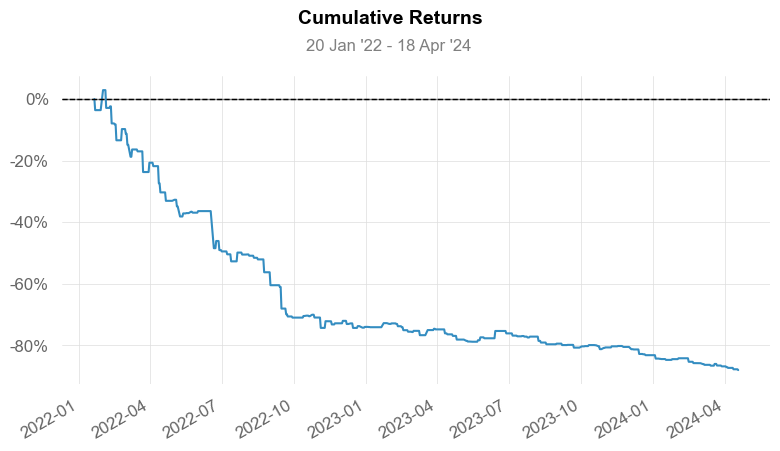

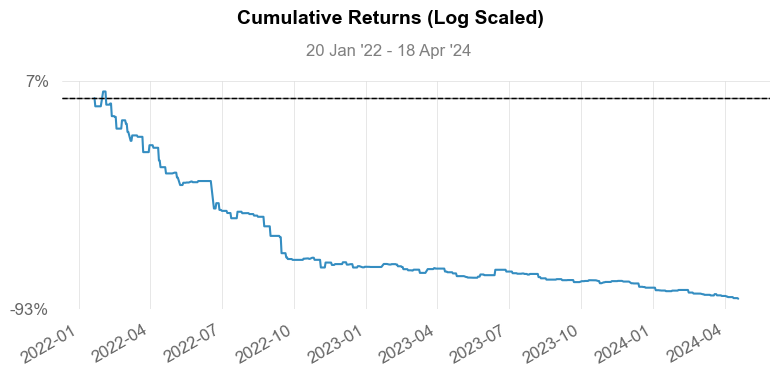

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


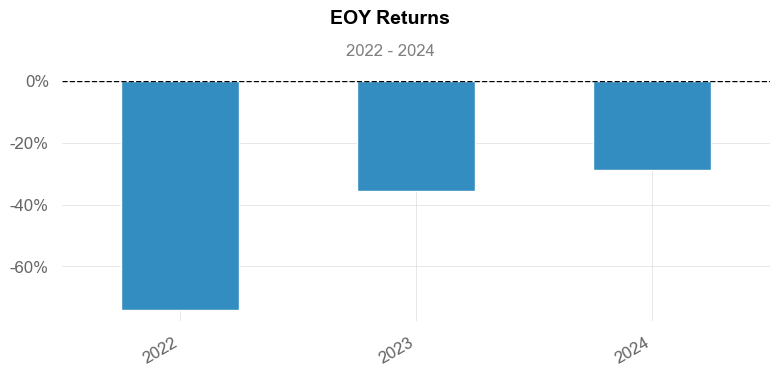

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

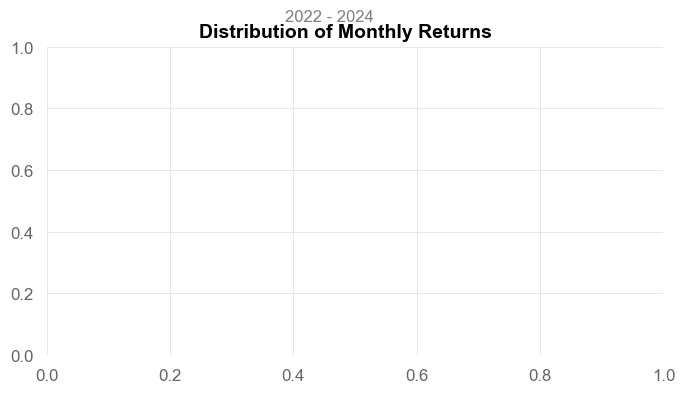

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')